# CODENATION - TRABALHO FINAL

Algumas empresas gostariam de saber quem são as demais empresas em um determinado mercado (população) que tem maior probabilidade se tornarem seus próximos clientes. Ou seja, a sua solução deve encontrar no mercado quem são os leads mais aderentes dado as características dos clientes presentes no portfólio do usuário.

Além disso, sua solução deve ser agnóstica ao usuário. Qualquer usuário com uma lista de clientes que queira explorar esse mercado pode extrair valor do serviço.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [2]:
empresas = pd.read_csv("dados_originais/estaticos_market.csv")
empresas = empresas.drop('Unnamed: 0', axis=1)
empresas.columns

Index(['id', 'fl_matriz', 'de_natureza_juridica', 'sg_uf',
       'natureza_juridica_macro', 'de_ramo', 'setor', 'idade_empresa_anos',
       'idade_emp_cat', 'fl_me',
       ...
       'media_meses_servicos', 'max_meses_servicos', 'min_meses_servicos',
       'qt_funcionarios', 'qt_funcionarios_12meses', 'qt_funcionarios_24meses',
       'tx_crescimento_12meses', 'tx_crescimento_24meses', 'tx_rotatividade',
       'qt_filiais'],
      dtype='object', length=181)

In [3]:
print("são {} empresas cadastradas".format(empresas.shape[0]))
print("são {} variáveis a serem avaliadas".format(empresas.shape[1]))

são 462298 empresas cadastradas
são 181 variáveis a serem avaliadas


## 1. Eliminando colunas

In [4]:
from limpeza_dados import LimpezaDados
limpeza = LimpezaDados()

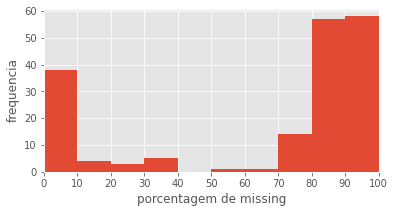

In [5]:
#Ver quantos valores missing eu tenho
aux = pd.DataFrame({'missing':((empresas.isna().sum()/empresas.shape[0])*100)})
plt.figure(figsize = (6,3))
plt.hist(aux['missing'], bins=10)
plt.xlim(0,100)
plt.xticks(range(0,101,10))
plt.xlabel('porcentagem de missing')
plt.ylabel('frequencia');

In [6]:
empresas = limpeza.remove_NA(empresas)

removendo colunas com mais de 70% de NA...ok


In [7]:
empresas = limpeza.remove_desnecessarias(empresas)
empresas.columns

removendo colunas desnecessárias para o projeto...ok


Index(['id', 'fl_matriz', 'de_natureza_juridica', 'sg_uf',
       'natureza_juridica_macro', 'de_ramo', 'setor', 'idade_empresa_anos',
       'idade_emp_cat', 'fl_me', 'fl_sa', 'fl_epp', 'fl_mei', 'fl_ltda',
       'fl_st_especial', 'fl_rm', 'nm_divisao', 'nm_segmento', 'fl_spa',
       'fl_antt', 'fl_veiculo', 'fl_optante_simples',
       'vl_total_veiculos_pesados_grupo', 'vl_total_veiculos_leves_grupo',
       'fl_optante_simei', 'sg_uf_matriz', 'de_saude_tributaria',
       'de_nivel_atividade', 'fl_simples_irregular',
       'empsetorcensitariofaixarendapopulacao', 'nm_meso_regiao',
       'nm_micro_regiao', 'fl_passivel_iss', 'qt_socios', 'qt_socios_pf',
       'qt_socios_pj', 'idade_media_socios', 'idade_maxima_socios',
       'idade_minima_socios', 'qt_socios_st_regular', 'qt_socios_masculino',
       'qt_socios_feminino', 'de_faixa_faturamento_estimado',
       'de_faixa_faturamento_estimado_grupo', 'vl_faturamento_estimado_aux',
       'vl_faturamento_estimado_grupo_aux', 'qt

In [8]:
empresas.to_csv("dados_trabalhados/empresas_limpa1.csv")

### Análise exploratória
A análise exploratória foi feita em outro notebook a partir desse novo arquivo criado. Durante a análise exploratória encontrei diversas colunas redundantes, muito desbalanceadas, autocorrelacionadas e aparentemente desnecessárias para minha análise:

In [9]:
limpeza.analise_exploratoria(empresas).columns

removendo colunas redundantes e desnecessárias para o projeto...ok


Index(['id', 'fl_matriz', 'sg_uf', 'de_ramo', 'idade_empresa_anos', 'fl_rm',
       'nm_divisao', 'nm_segmento', 'fl_optante_simples',
       'vl_total_veiculos_pesados_grupo', 'vl_total_veiculos_leves_grupo',
       'fl_optante_simei', 'de_nivel_atividade',
       'empsetorcensitariofaixarendapopulacao', 'nm_meso_regiao',
       'fl_passivel_iss', 'qt_socios', 'idade_media_socios',
       'vl_faturamento_estimado_grupo_aux', 'qt_filiais'],
      dtype='object')

In [10]:
empresas.to_csv("dados_trabalhados/empresas_limpa2.csv")

## 2. Tratando features

### Tratando as categóricas

In [11]:
from limpeza_dados import Tratamento
tratamento = Tratamento()

In [12]:
empresas = tratamento.tratando_categoricas(empresas)

transformando nível de atividade em números...ok
transformando alguns dados em booleanos...ok
preenchendo os NA de meso_região com valores de UF correspondentes...ok
preenchendo dados de divisao e segmento vazios com OUTROS...ok


In [13]:
categoricas = empresas.select_dtypes('object')

pd.DataFrame({'missing': categoricas.isna().sum()/categoricas.shape[0]*100,
              'tipos': categoricas.dtypes,
              'unicos': categoricas.nunique()}
            ).sort_values(by='missing', ascending=False)

,missing,tipos,unicos
id,0.0,object,462298
sg_uf,0.0,object,6
de_ramo,0.0,object,33
nm_divisao,0.0,object,88
nm_segmento,0.0,object,22
nm_meso_regiao,0.0,object,25


In [14]:
booleanos = empresas.select_dtypes('bool')

pd.DataFrame({'missing': booleanos.isna().sum()/booleanos.shape[0]*100,
              'tipos': booleanos.dtypes,
              'unicos': booleanos.nunique()}
            ).sort_values(by='missing', ascending=False)

,missing,tipos,unicos
fl_matriz,0.0,bool,2
fl_rm,0.0,bool,2
fl_optante_simples,0.0,bool,2
fl_optante_simei,0.0,bool,2
fl_passivel_iss,0.0,bool,2


### Tratando numéricas

In [15]:
empresas = tratamento.tratando_numericas(empresas)

imputando os NA com a média...ok


In [16]:
numericas = empresas.select_dtypes('number')

pd.DataFrame({'missing': numericas.isna().sum()/numericas.shape[0]*100,
              'tipos': numericas.dtypes}
            ).sort_values(by='missing', ascending=False)

,missing,tipos
idade_empresa_anos,0.0,float64
vl_total_veiculos_pesados_grupo,0.0,float64
vl_total_veiculos_leves_grupo,0.0,float64
de_nivel_atividade,0.0,float64
empsetorcensitariofaixarendapopulacao,0.0,float64
qt_socios,0.0,float64
idade_media_socios,0.0,float64
vl_faturamento_estimado_grupo_aux,0.0,float64
qt_filiais,0.0,int64


In [17]:
empresas = tratamento.padronizando_numericas(empresas)

padronizando as variáveis numéricas...ok


In [18]:
empresas.to_csv("dados_trabalhados/empresas_limpa3.csv")

## 3. Modelo

In [19]:
from sklearn.cluster import KMeans
from modelo import Modelo
model = Modelo()

In [20]:
df = pd.read_csv("dados_trabalhados/empresas_limpa3.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)

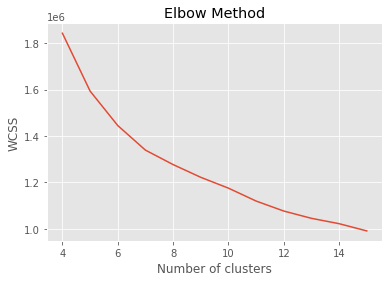

In [21]:
features = ['idade_empresa_anos', 'fl_rm', 'nm_segmento', 'vl_total_veiculos_pesados_grupo',
            'de_nivel_atividade', 'sg_uf', 'qt_socios','vl_faturamento_estimado_grupo_aux', 'qt_filiais']
X = df[features]
X_dummies = pd.get_dummies(X)
X_dummies.columns.nunique()

wcss = []

for i in range(4, 16, 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_dummies)
    wcss.append(kmeans.inertia_)

plt.plot(range(4, 16, 1), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [22]:
X = model.pre_modelo(df)

selecionando as features...ok
aplicando get_dummies nas variáveis categóricas...ok


In [23]:
X.to_csv("dados_trabalhados/empresas_premodelo.csv")

In [24]:
X = pd.read_csv("dados_trabalhados/empresas_premodelo.csv")
X.drop('Unnamed: 0', axis=1, inplace=True)

In [25]:
clusters = model.kmeans(X, 7)

aplicando k-means no dataframe...ok


In [26]:
id_cluster = pd.DataFrame({'id':df.id,
                           'segmento':df.nm_segmento,
                           'clusters':clusters.clusters})
id_cluster

,id,segmento,clusters
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,CONSTRUCAO,3
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,ALOJAMENTO E ALIMENTACAO,0
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,TRANSPORTE ARMAZENAGEM E CORREIO,1
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,OUTRAS ATIVIDADES DE SERVICOS,1
4,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,ATIVIDADES PROFISSIONAIS CIENTIFICAS E TECNICAS,3
...,...,...,...
462293,469ee5fc984d0bb60aa2f40cda4d003d7c9b963d149ed3...,COMERCIO; REPARACAO DE VEICULOS AUTOMOTORES E ...,3
462294,656f496e7e2fad708f0022d8ad97d2cb9344e839a5f3cb...,ATIVIDADES ADMINISTRATIVAS E SERVICOS COMPLEME...,0
462295,9b933a5cf2149d1338f00fb459d34a16b9b0f2e8d3e8e1...,SAUDE HUMANA E SERVICOS SOCIAIS,4
462296,84db0f17467cf4f02439e01ade57150b6ac59d9dae53ed...,COMERCIO; REPARACAO DE VEICULOS AUTOMOTORES E ...,3


In [27]:
id_cluster.to_csv("dados_trabalhados/ids_clusters.csv")

## 4. Recomendação

In [28]:
from unindo_df import UnindoDF
from recomenda_empresas import Recomendação

### Ver quais principais clusters da empresa 1

In [29]:
empresa1 = pd.read_csv("dados_originais/estaticos_portfolio1.csv")
empresa1 = empresa1.drop('Unnamed: 0',axis=1)
print('a empresa 1 tem',empresa1.shape[0],'empresas clientes')

a empresa 1 tem 555 empresas clientes


In [30]:
unir = UnindoDF()
empresa1 = unir.unir_df(id_cluster, empresa1)

In [31]:
#para recomendar o cluster mais comum da empresa1
recomendacao = Recomendação()
cluster_rec = recomendacao.cluster_rec(empresa1)

vendo qual o cluster predominante no dataframe...ok


### Recomendar com base no segmento da empresa e no cluster

In [32]:
#supondo que quero recomendacao de COMERCIO; REPARACAO DE VEICULOS AUTOMOTORES E MOTOCICLETAS para empresa 1:
segmento = 'COMERCIO; REPARACAO DE VEICULOS AUTOMOTORES E MOTOCICLETAS'

empresas_rec = recomendacao.recomenda(cluster_rec, segmento, empresa1)
print('é possível recomendar',len(empresas_rec),'empresas para a empresa 1')

verificando quais empresas desse segmento correspondem ao cluster mais aderente a empresa...ok
é possível recomendar 73650 empresas para a empresa 1


In [33]:
empresas_rec[0:5]

['3d280e33e53e6fa5d63791f1eaf0207f2c079d1d7131759a3c7670c8e9df7c05',
 '459303e2f53eafe5c018c516d21f1cad65ab8a82c7214e0d7403e3cf38e6aa34',
 '4e663ebb51860ea4882099302347f35f3f255e184c3849247244a8f1d7bd7c16',
 '0032e3e6a776cbf4d36efa963b4eda224ddba8af284117273bbd7a2a9d374f96',
 'e93a20892b53018debe7454c6a1525b3c387a4d8338b50468ffce3dc77bd3683']